In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(18,8))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client

<Client: 'inproc://137.129.155.67/31347/1' processes=1 threads=4, memory=78.61 GiB>

In [2]:
def isLeapYear (yearN):
    if ((yearN % 4 == 0) and (yearN % 100 != 0)) or (yearN % 400 == 0):
        reponse = True
    else:
        reponse = False
    print(reponse, '\n')
    return reponse

def hour_mean(x):
     return x.groupby('time.hour').mean('time')
    
def hour_sum(x):
     return x.groupby('time.hour').sum('time')
    
def hour_std(x):
     return x.groupby('time.hour').std('time')

In [3]:
indir_smot = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/SMOTHED_CLIM/'
indir_brut = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_CLIM/'
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'

output_fig = '/cnrm/tropics/commun/DATACOMMUN/WAVE/RAPPORT/FIGURES/ANOMALY/OLR/'

var = 'toa_lw_all_1h'

ds_smot = xr.open_mfdataset(indir_smot+'clim_OLR_smooth_ERA5_*.nc', chunks = {'time' : 1}, parallel=True)
ds_brut = xr.open_mfdataset(indir_brut+'clim_toa_lw_all_1h_brut_ERA5_3H_2000_2020.nc', chunks = {'time' : 1}, parallel=True)

#ds_smot = xr.open_mfdataset(indir_smot+'*'+var+'*.nc', chunks = 'auto')

ds_brut

<xarray.Dataset>
Dimensions:        (time: 2928, lat: 60, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 1904-01-01 ... 1904-12-31T21:00:00
  * lat            (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    toa_lw_all_1h  (time, lat, lon) float32 dask.array<chunksize=(1, 60, 360), meta=np.ndarray>

In [4]:
# ds_anom = xr.open_mfdataset(indir_anom+'*.nc', engine='h5netcdf', chunks = {'time' : 1}, parallel=True)
filenames = np.arange(2001,2013)
datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + '*'+str(f)+'*.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds_anom['time'] = pd.date_range(start="2001", end="2012-12-31 22:00:00", freq='3H')
ds_anom

filenames = np.arange(2014,2020)
datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + '*'+str(f)+'*.nc', chunks={'time': 150})
    datasets.append(ds)
_ds_anom = xr.concat(datasets, dim='time', coords='minimal', compat='override')
_ds_anom['time'] = pd.date_range(start="2014", end="2019-12-31 22:00:00", freq='3H')
ds_anom = xr.concat([ds_anom, _ds_anom] , dim='time', coords='minimal', compat='override')
# ds_anom_T = ds_anom.sel(time = slice("20"))
ds_anom

<xarray.Dataset>
Dimensions:  (time: 52592, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2019-12-31T21:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Data variables:
    OLR_ano  (time, lat, lon) float64 dask.array<chunksize=(150, 60, 360), meta=np.ndarray>

# Verification de la climatologie en 1D
## Moyenne des anomalies + climatologie
\begin{equation}
X= \overline{x^{*}} + \overline{x}
\end{equation}

avec $\overline{x}\rightarrow$ ds_smot \\\
et $\overline{x^{*}}\rightarrow$ ds_mean_anom \\\
$X\rightarrow$ ds_tot

In [5]:
ds_mean_anom = ds_anom.mean('time')

da_tot = ds_mean_anom['OLR_ano'] + ds_smot['toa_lw_all_1h']
# da_tot_T = ds_mean_anom_T['tcwv_ano'] + ds_smot['tcwv_smooth']

##### Sur la période 1990-2020

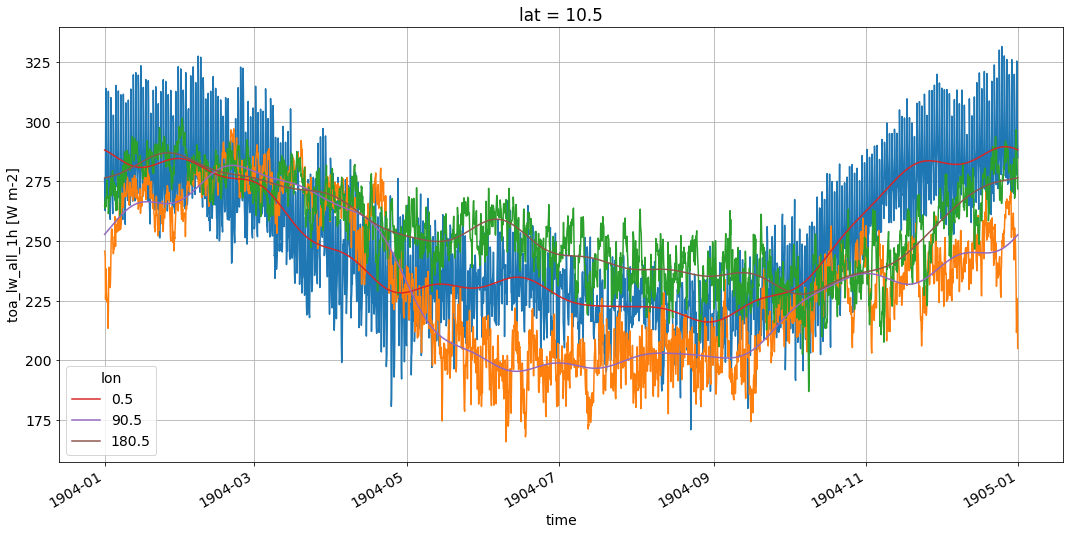

In [6]:
latitude = 10
longitude = [0, 90, 180]

plt.figure()
ds_brut['toa_lw_all_1h'].sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
ds_smot['toa_lw_all_1h'].sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
# da_tot.sel(lat = latitude, lon = longitude, method = 'nearest').plot(hue='lon')
# da_tot_T.sel(latitude = latitude, longitude = longitude).plot(hue='longitude')
plt.grid()
# plt.legend()
plt.show()

 ##### Sur la période 2012-2016

## Comparaison entre deux années ou période

# Verification pour l'anomalie en 2D pour 1990-2010
## Moyennes mensuelle et saisonnière
\begin{equation}
\overline{tcwv}_j = \frac{\displaystyle\sum_{i=1}^{n_j}x_i} {n_j} = \mu_j\\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$} \\[30pt]
\end{equation}

#### Carte global de l'anomalie de PW en moyenne mensuelle

In [11]:
ds_MMS = ds_anom.groupby("time.month").mean('time').load()
ds_MSS = ds_anom.groupby('time.season').mean('time').load()
ds_MMS

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 60, month: 12)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OLR_ano  (month, lat, lon) float64 0.07594 0.06065 0.01332 ... 0.145 0.1138

In [13]:
#### Parameter for plotting
vmax = 5
vmin = -vmax
cmap ='RdBu_r'
size = 5
aspect = 4

colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,2),
            'extend' : 'both'}


map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


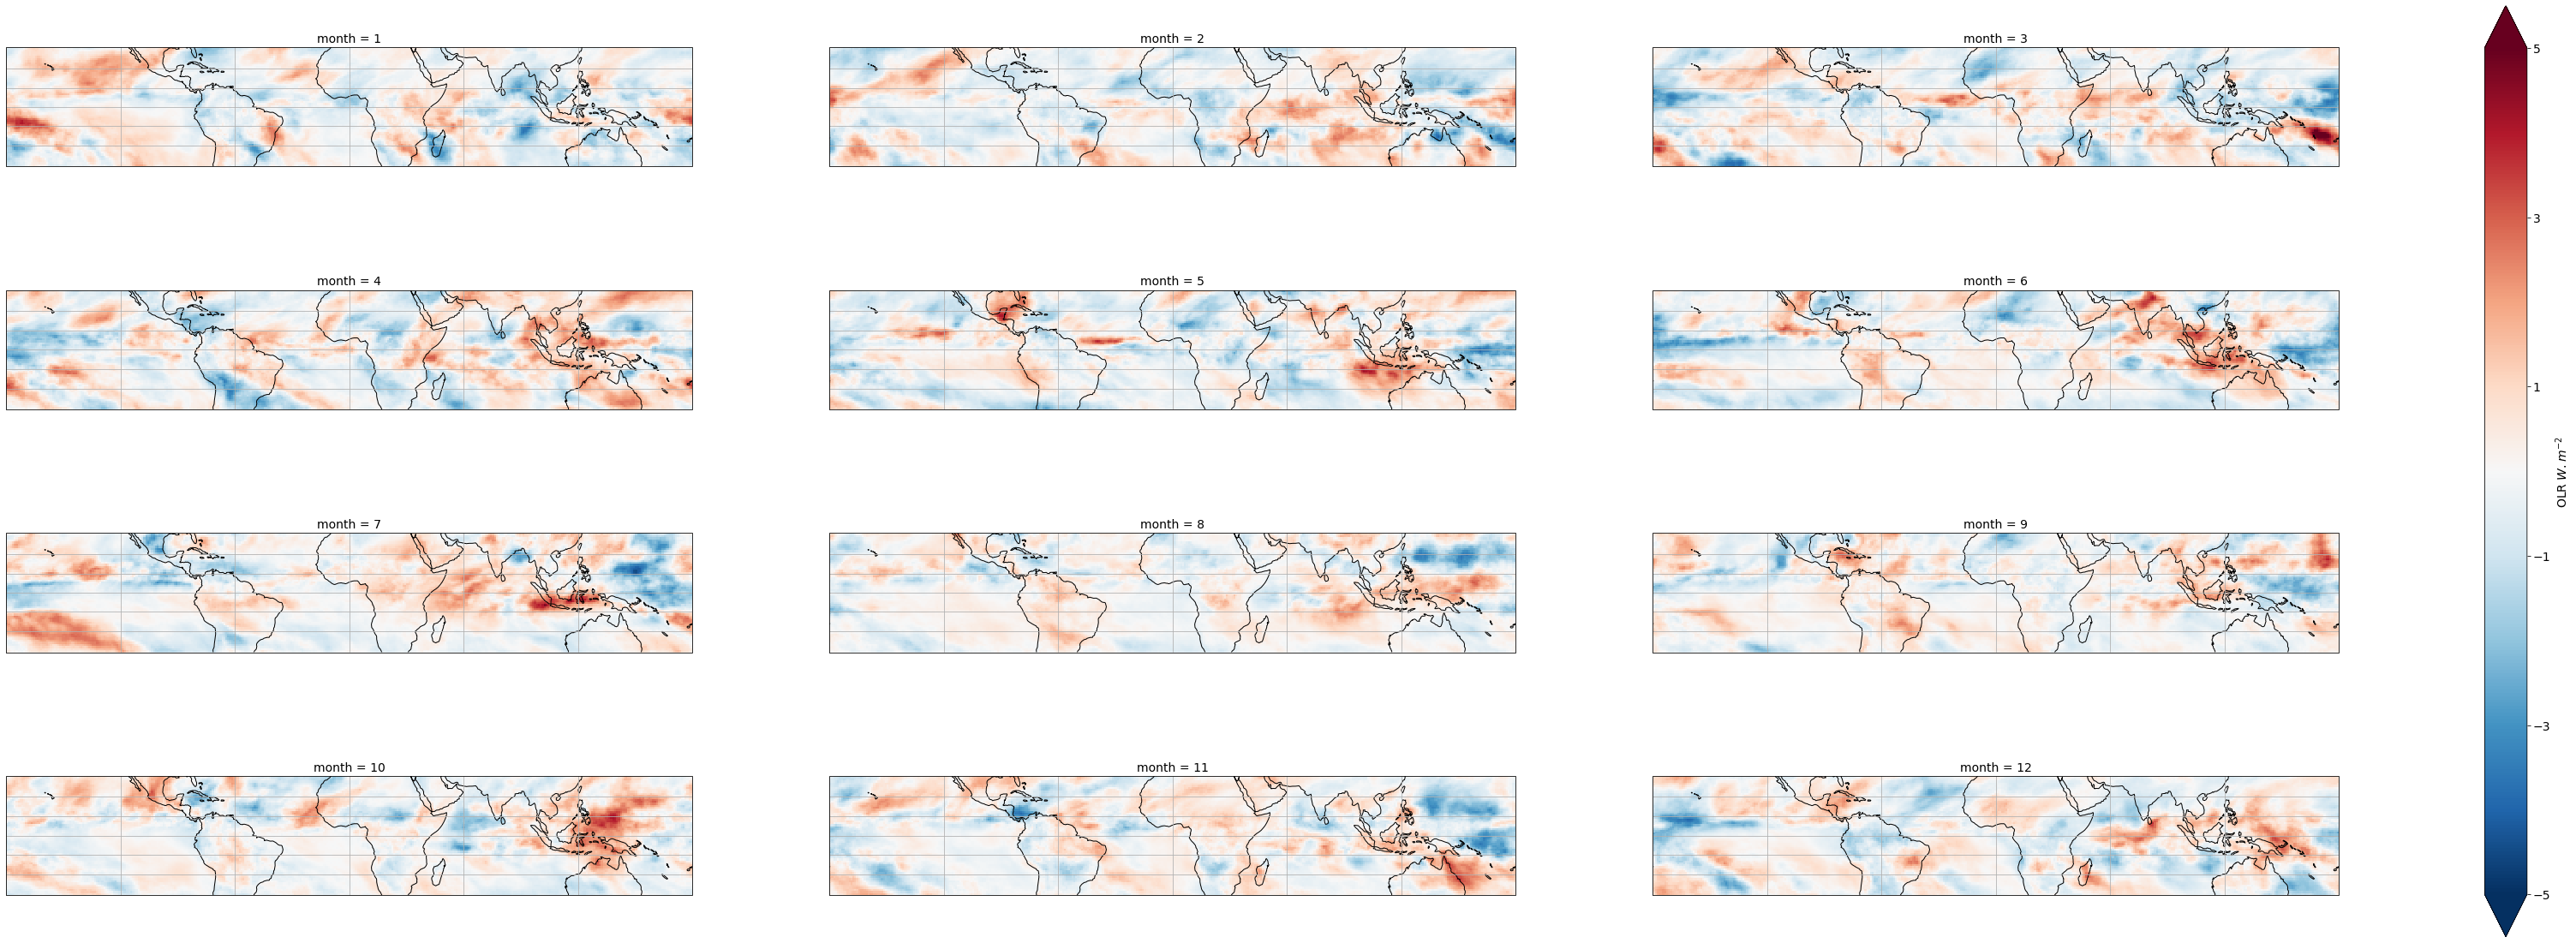

In [14]:
p = ds_MMS['OLR_ano'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.savefig(output_fig+'atlas_meanMonth_anomaly.png')  

#### Carte global de l'anomalie de PW en moyenne saisonnière

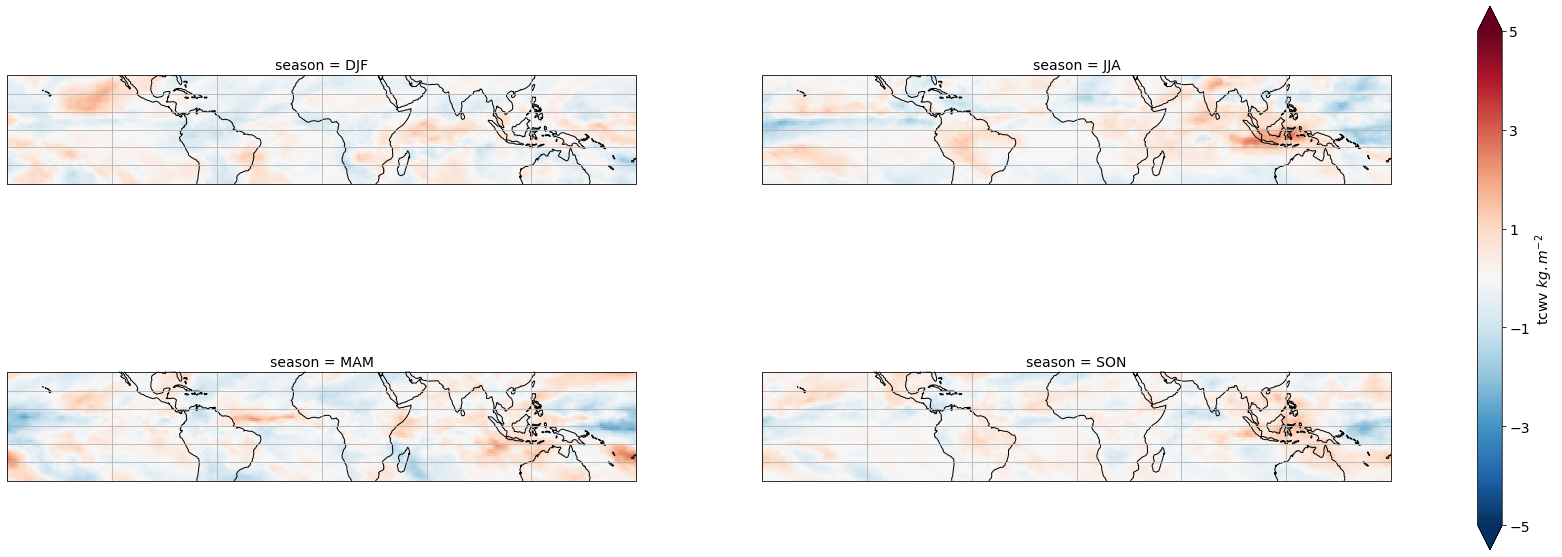

In [16]:
p = ds_MSS['OLR_ano'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = 3, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.savefig(output_fig+'atlas_meanSeason_anomaly.png')



## Calcul de l'écart-type pour l'anomalie
\begin{equation}
\sigma = \sqrt{\frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu_i)^2} {n}} \\
\text{avec n le nombre de pas de temps total,  $\mu$ la moyenne climatologique au pas de temps} \\[30pt]
\sigma_j = \sqrt{\frac{\displaystyle\sum_{i=1}^{n_j}(x_i - \mu_i)^2} {n_j}} \\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu_i$ la moyenne climatologique au pas de temps, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$}
\end{equation}



In [16]:
# import xarray.ufuncs as xu

# # n
# # test = xr.apply_ufunc(lambda x, m, n: (x - m)**2/n , ds_anom, ds_mean_anom, n)
# ds_anom #- ds_mean_anom
# # ds_mean_anom

# def isLeapYear(yearN):
#     if ((yearN % 4 == 0) and (yearN % 100 != 0)) or (yearN % 400 == 0):
#         reponse = True
#     else:
#         reponse = False
#     return reponse

# def is_jja(month):
#     return (month >= 6) & (month <= 8)

# # seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
# n_j = 0
# _ds_mean_anom = ds_mean_anom.sel(time=is_jja(ds_mean_anom['time.month']))
# subDs = []
# for y in range(1990,2021) :
#     _ds = ds_anom.sel(time = str(y))
#     _ds = _ds.sel(time=is_amj(_ds['time.month']))
# #     if isLeapYear(_ds.time.dt.year[0].values) == True :
#     _ds_mean_anom['time'] = _ds.time
#     _dsSub = (_ds - _ds_mean_anom)**2
#     n_j = n_j + len(_dsSub.time.values)

        
# #     else :
# #         _ds_mean_anom = ds_mean_anom.isel(time = slice(None,-int(24/3)))
# #         _ds_mean_anom['time'] = _ds.time
# #         _dsSub = xu.square(_ds - _ds_mean_anom )
        
#     subDs.append(_dsSub)
# dsSub = xr.concat(subDs, dim='time', coords='minimal', compat='override')
# dsSub = xu.sqrt(dsSub['tcwv_ano'].sum('time')/n_j)
# # dsSub['tcwv_ano'].sum('time')
# dsSub
#ds_std_anom_S.sel(season='JJA')

# fig, axis = plt.subplots(
#     1, 1, subplot_kw={'projection': map_proj})

# ds_std_anom_S['tcwv_ano'].sel(season='JJA').plot.contourf(ax=axis, levels = 101,
#                     transform=ccrs.PlateCarree(),
#                     vmin = 0., vmax = 10, cmap=cmap,# multiplot settings
#                     cbar_kwargs=colorbar)

# # p = dsSub.plot.contourf(ax = None, aspect = 3, size = 3, transform=ccrs.PlateCarree(),
# #                          col_wrap = 1,
# #                                vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
# #                                subplot_kws={'projection': map_proj},
# #                                cbar_kwargs=colorbar)
# axis.coastlines()
# plt.title("Standard deviation JJA")
# plt.show()

In [5]:
ds_std_anom  = xu.square(ds_anom.std('time'))
ds_std_anom_M = xu.square(ds_anom.groupby("time.month").std('time').load())
ds_std_anom_S= xu.square(ds_anom.groupby("time.season").std('time').load())

In [13]:
vmax = 3000.
vmin = 0.
cmap ='RdBu'
size = 5
aspect = 4

#### Parameter for plotting
colorbar = {'label': 'OLR $W^{2}.m^{-4}$',
            'orientation': 'vertical' , 'ticks': np.linspace(vmin,vmax,10),
            'extend' : 'max'}

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#### Atlas de la variance sur les douze mois 

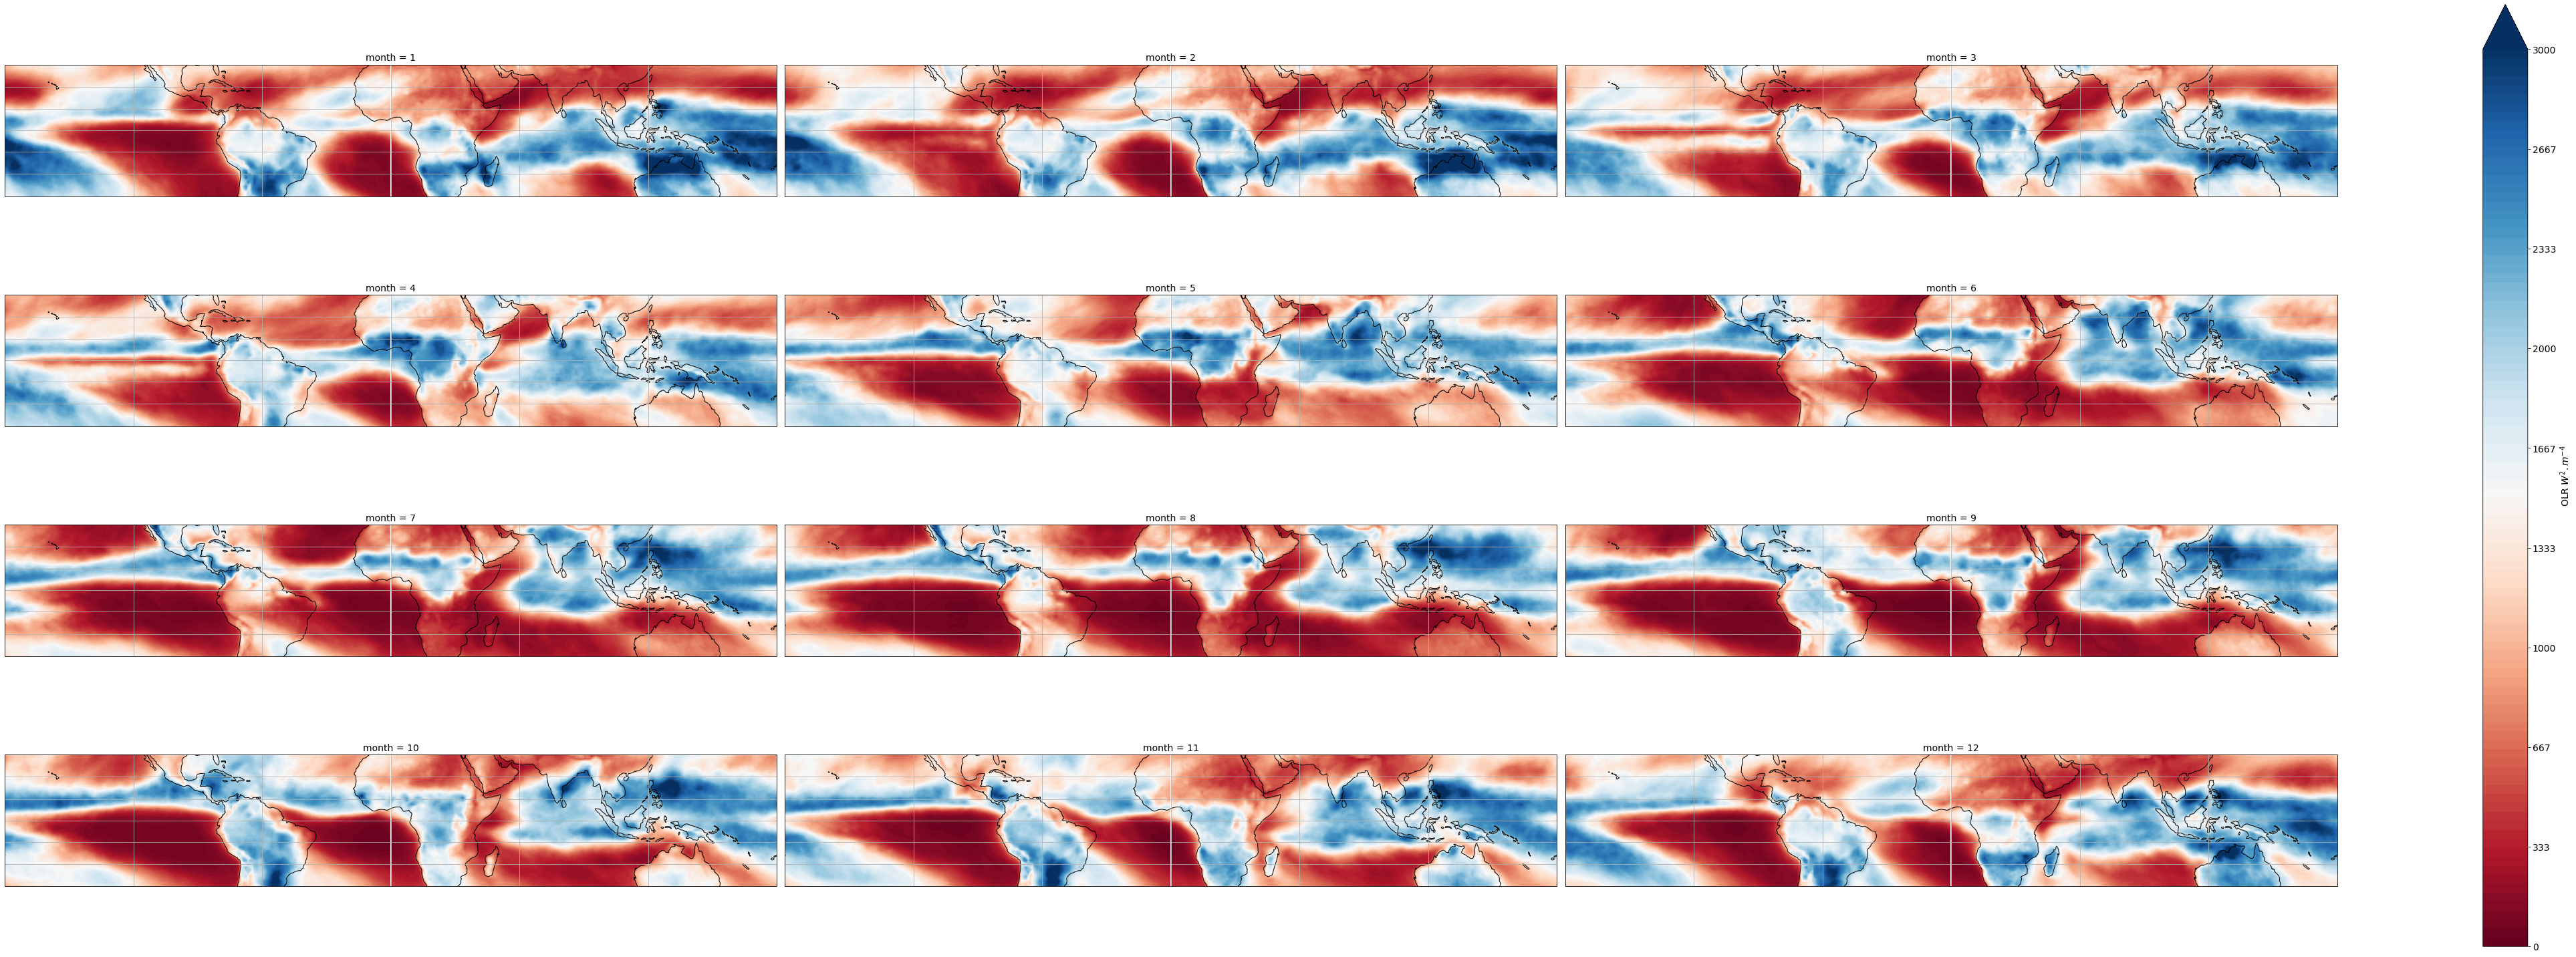

In [14]:
p = ds_std_anom_M['OLR_ano'].plot.contourf(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3, levels = 101,
                               aspect = aspect, size = size,
                               vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)

for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
# plt.show()
plt.savefig(output_fig+'atlas_varMonth_anomaly.png')

#### Atlas de la variance saisonière

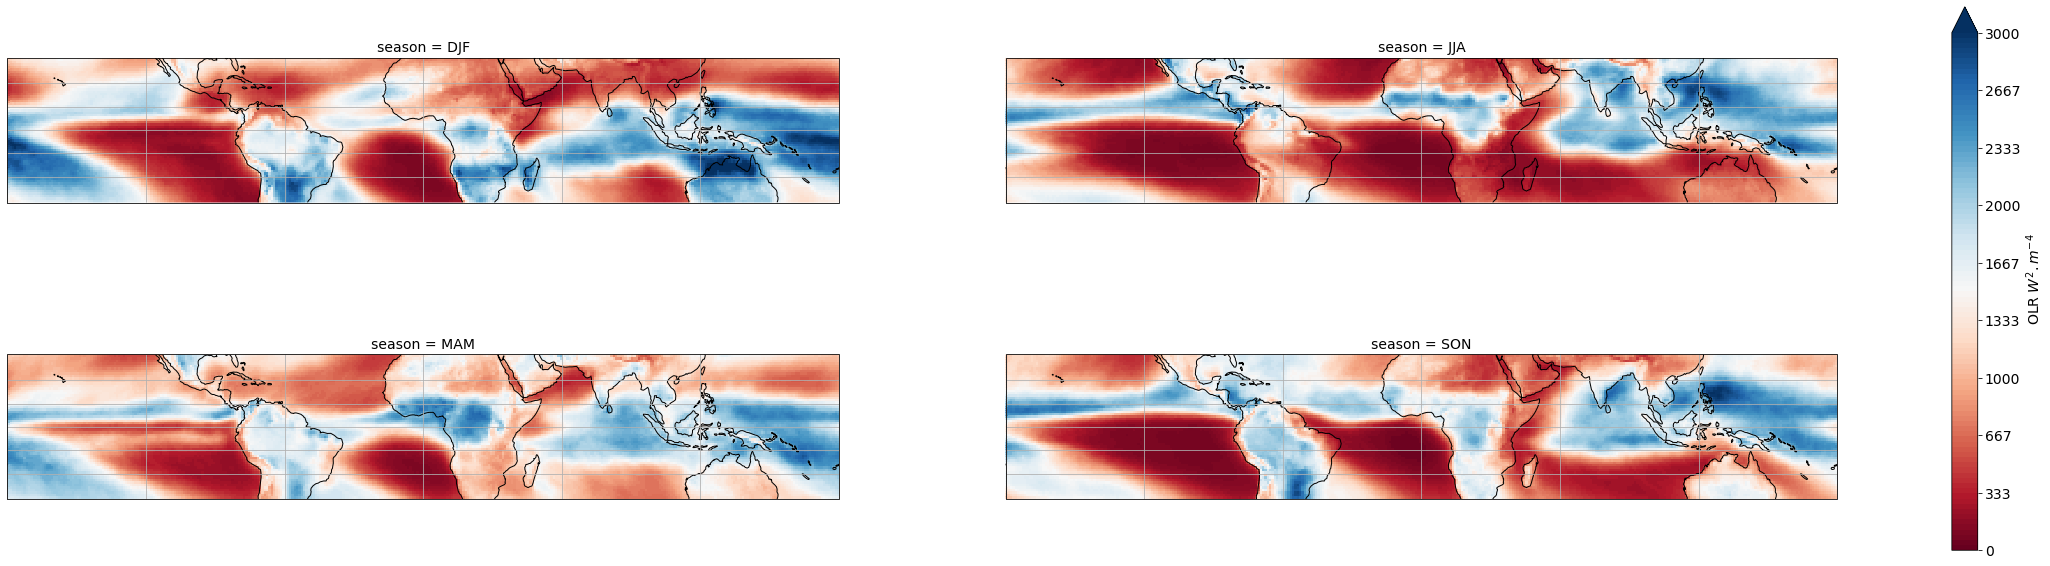

In [16]:
p = ds_std_anom_S['OLR_ano'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2, levels = 101,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                              cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.savefig(output_fig+'atlas_OLR_varSeason_anomaly.png')

#### Atlas de la variance annuelle

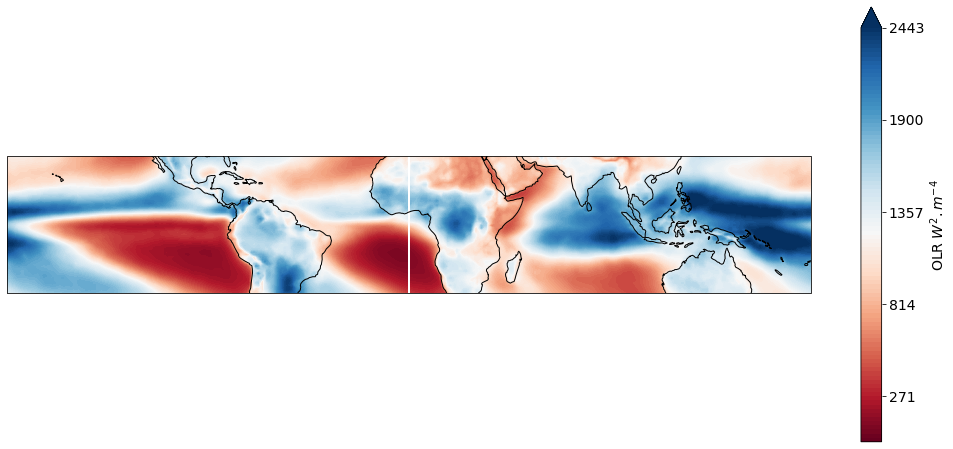

In [52]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom['OLR_ano'].plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
plt.savefig(output_fig+'atlas_varYear_anomaly.png')

# Verification de l'anomalie en 2D pour TOUCAN
## Moyennes mensuelle et saisonnière
\begin{equation}
\overline{tcwv}_j = \frac{\displaystyle\sum_{i=1}^{n_j}x_i} {n_j} = \mu_j\\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$} \\[30pt]
\end{equation}


#### Carte global de l'anomalie de PW en moyenne mensuelle



## Calcul de la variance pour l'anomalie
\begin{equation}
\sigma^2 = \frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu)^2} {n} \\
\text{avec n le nombre de pas de temps total,  $\mu$ la moyenne sur l'année} \\[30pt]
\sigma^2_j = \frac{\displaystyle\sum_{i=1}^{n_j}(x_i - \mu_j)^2} {n_j} \\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu_j$ la moyenne mensuelle ou saisonière, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$}
\end{equation}



#### Atlas de la variance sur les douze mois 

#### Atlas de la variance saisonière